### Purpose : Which ad platform is more effective in terms of conversions,clicks and over all cost effectiveness ?


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import coint

file_path = r"E:\Projects\Paid Ads Efficiency Facebook vs AdWords\data\processed\marketing_cleaned.csv"

df = pd.read_csv(file_path, parse_dates=['date'])


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   date                                         365 non-null    datetime64[ns]
 1   facebook_ad_campaign                         365 non-null    object        
 2   facebook_ad_views                            365 non-null    int64         
 3   facebook_ad_clicks                           365 non-null    int64         
 4   facebook_ad_conversions                      365 non-null    int64         
 5   cost_per_facebook_ad                         365 non-null    float64       
 6   facebook_click_through_rate_clicks_view      365 non-null    float64       
 7   facebook_conversion_rate_conversions_clicks  365 non-null    float64       
 8   facebook_cost_per_click_ad_cost_clicks       365 non-null    float64       
 9  

### Distrubution of clicks and conversions

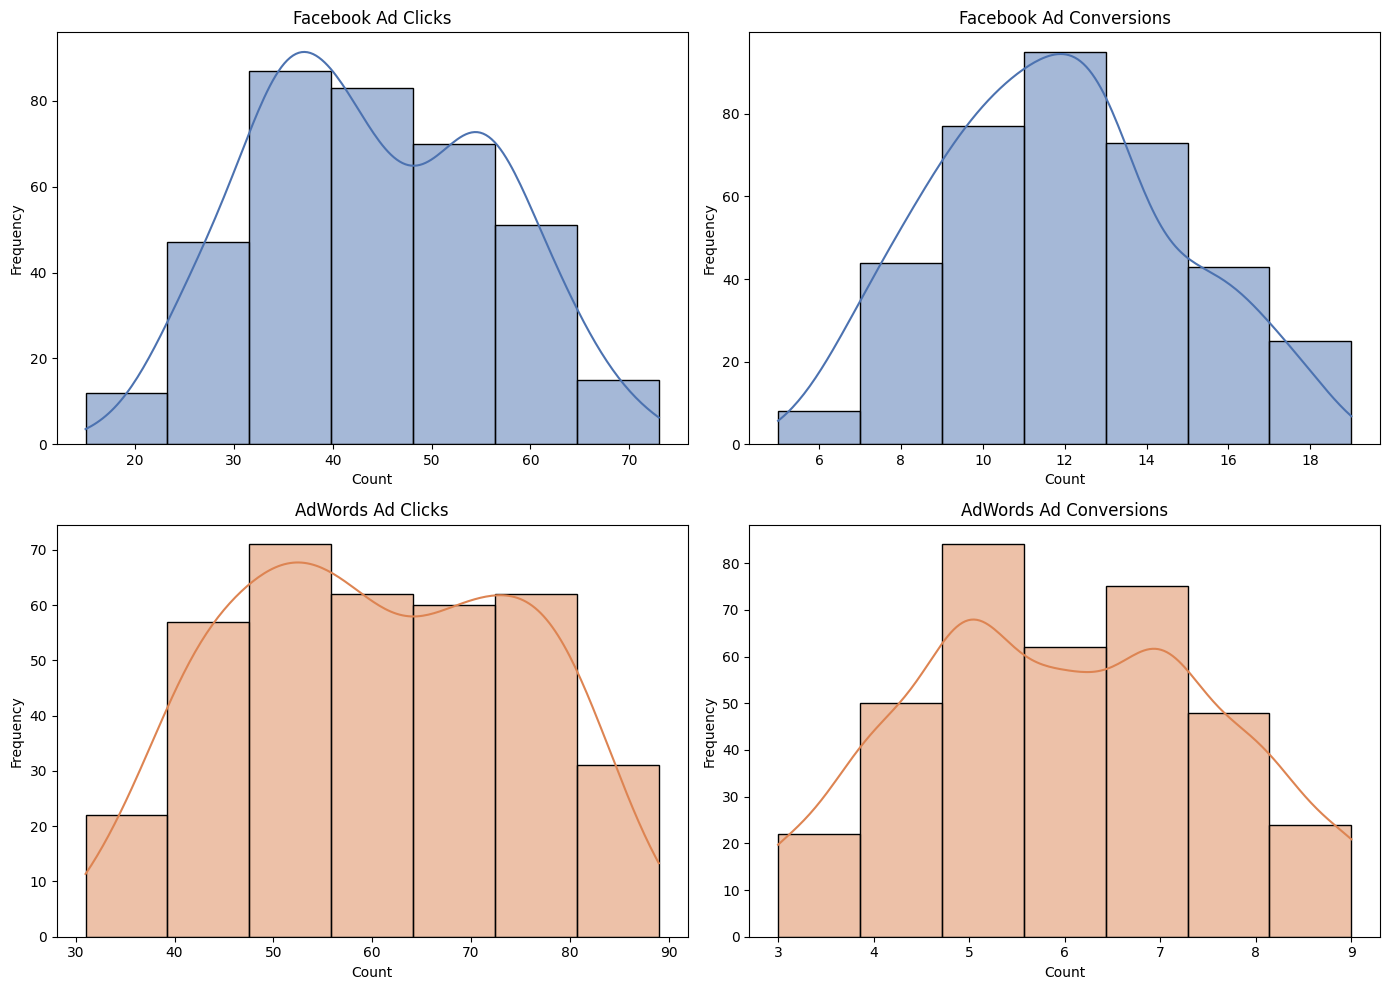

In [37]:
plt.figure(figsize=(14,10))

# Define columns and logo colors
cols = [
    ('facebook_ad_clicks', 'Facebook Ad Clicks', '#4C72B0'),
    ('facebook_ad_conversions', 'Facebook Ad Conversions', '#4C72B0'),
    ('adwords_ad_clicks', 'AdWords Ad Clicks', '#DD8452'),   
    ('adwords_ad_conversions', 'AdWords Ad Conversions', '#DD8452')
]

for i, (col, title, color) in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=7, edgecolor='k', kde=True, color=color)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

ADWORDS_COLOR  = "#DD8452"  
FACEBOOK_COLOR = '#4C72B0'


**Distribution Patterns**
- Roughly symmetrical histograms indicate clicks and conversions evenly distributed around the mean
- No extreme outliers on high or low end
- Stable, consistent performance over time—not driven by rare spikes

### How frequently do we observe days with high numbers of conversions compared to days with low numbers of conversions?

In [11]:
# define bins and labels
bins = [0, 5, 10, 15, float('inf')]
labels = ['<6', '6–10', '11–15', '>15']

# Facebook conversion categories
df['facebook_conversion_category'] = pd.cut(
    df['facebook_ad_conversions'],
    bins=bins,
    labels=labels
)

# AdWords conversion categories
df['adwords_conversion_category'] = pd.cut(
    df['adwords_ad_conversions'],
    bins=bins,
    labels=labels
)


In [12]:
df['adwords_conversion_category'].value_counts(normalize=True)


adwords_conversion_category
6–10     0.572603
<6       0.427397
11–15    0.000000
>15      0.000000
Name: proportion, dtype: float64

In [13]:
df['facebook_conversion_category'].value_counts(normalize=True)


facebook_conversion_category
11–15    0.517808
6–10     0.350685
>15      0.128767
<6       0.002740
Name: proportion, dtype: float64

In [14]:
conversion_category_dist = pd.DataFrame({
    'facebook': df['facebook_conversion_category'].value_counts(normalize=True),
    'adwords': df['adwords_conversion_category'].value_counts(normalize=True)
}).fillna(0)

conversion_category_dist


,facebook,adwords
<6,0.002740,0.427397
6–10,0.350685,0.572603
11–15,0.517808,0.000000
>15,0.128767,0.000000


Histogram (Conversion Distribution / Risk Profile)

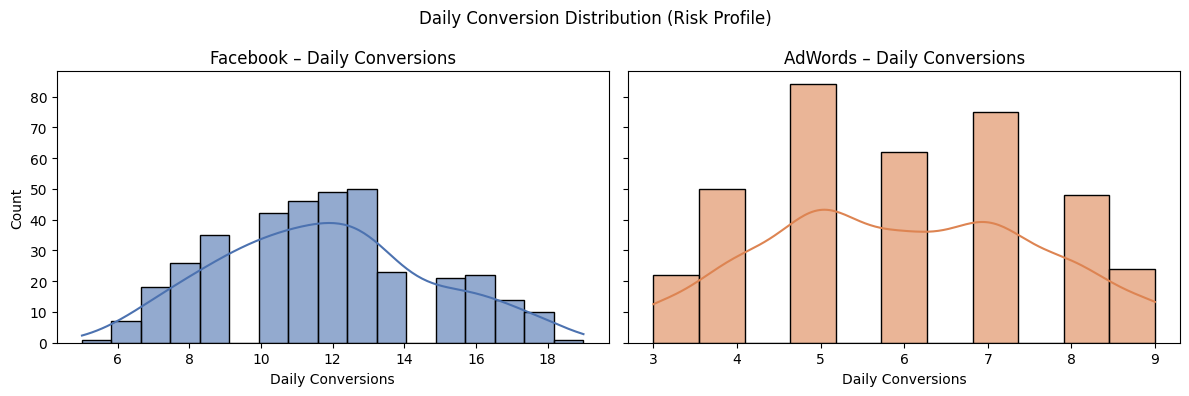

In [15]:
ADWORDS_COLOR  = "#DD8452"  
FACEBOOK_COLOR = '#4C72B0'

ALPHA = 0.6

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(
    df['facebook_ad_conversions'],
    kde=True,
    ax=axes[0],
    color=FACEBOOK_COLOR,
    alpha=ALPHA
)
axes[0].set_title("Facebook – Daily Conversions")
axes[0].set_xlabel("Daily Conversions")

sns.histplot(
    df['adwords_ad_conversions'],
    kde=True,
    ax=axes[1],
    color=ADWORDS_COLOR,
    alpha=ALPHA
)
axes[1].set_title("AdWords – Daily Conversions")
axes[1].set_xlabel("Daily Conversions")

plt.suptitle("Daily Conversion Distribution (Risk Profile)")
plt.tight_layout()
plt.show()


Daily Conversion Variability

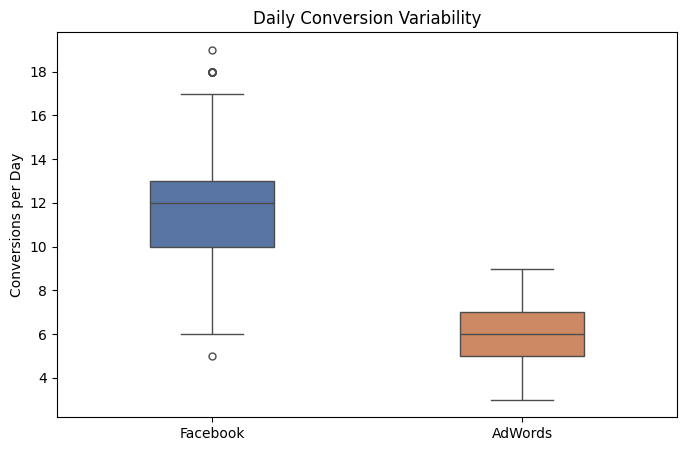

In [35]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'
ALPHA = 0.8

plt.figure(figsize=(8, 5))

df_long = df[['facebook_ad_conversions', 'adwords_ad_conversions']].melt(
    var_name='Platform', value_name='Conversions'
)

df_long['Platform'] = df_long['Platform'].replace({
    'facebook_ad_conversions': 'Facebook',
    'adwords_ad_conversions': 'AdWords'
})

ax = sns.boxplot(
    data=df_long,
    x='Platform',
    y='Conversions',
    hue='Platform',              # 🔑 fix
    palette={
        'Facebook': FACEBOOK_COLOR,
        'AdWords': ADWORDS_COLOR
    },
    width=0.4,
    fliersize=5,
    linewidth=1,
    legend=False                 # 🔕 remove duplicate legend
)

# Apply alpha correctly
for patch in ax.artists:
    patch.set_alpha(ALPHA)

plt.title("Daily Conversion Variability")
plt.ylabel("Conversions per Day")
plt.xlabel("")
plt.show()


Conversion Category Proportions

<Figure size 800x500 with 0 Axes>

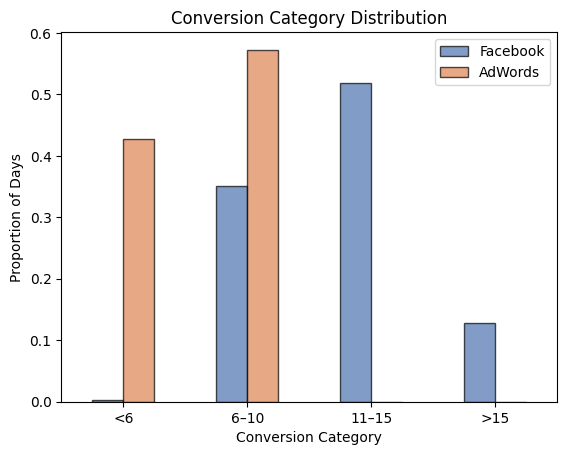

In [17]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'
ALPHA = 0.7

plt.figure(figsize=(8,5))

conversion_category_dist.plot(
    kind='bar',
    color=[FACEBOOK_COLOR, ADWORDS_COLOR],
    alpha=ALPHA,
    edgecolor='black',
    linewidth=1
)

plt.title("Conversion Category Distribution")
plt.xlabel("Conversion Category")
plt.ylabel("Proportion of Days")
plt.xticks(rotation=0)
plt.legend(["Facebook", "AdWords"])
plt.show()


**Performance Disparities**
- Facebook outperforms AdWords 5-7x in conversion volume (35-50 daily vs 4-9)
- Facebook shows wider range (median ~12, IQR 10-13, peaks 18+) vs AdWords tight clustering (median ~6, IQR 5-7, peaks 9)

**Conversion Quality**
- AdWords skews low-value: 29% in 6-10 range, 21% below 6
- Facebook dominates mid-high value: 26% in 11-15 range, 6% above 15, virtually 0% below 6
- AdWords essentially 0% in 11-15 and >15 ranges

**Strategic Implications**
- Facebook delivers higher volume and quality. AdWords generates mostly low-value conversions with poor consistency. Optimize AdWords strategy or reallocate budget to Facebook.

## Does more clicks mean more revenue/sales ?

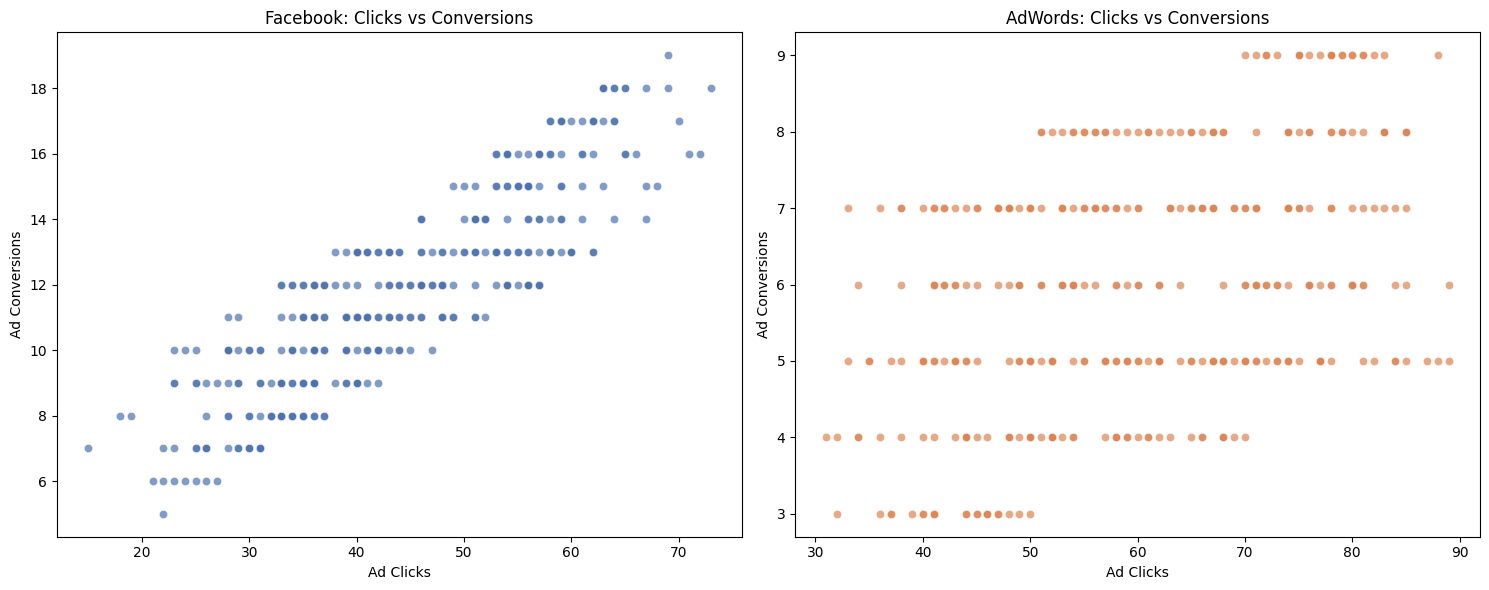

In [18]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'

plt.figure(figsize=(15, 6))

# Facebook
plt.subplot(1, 2, 1)
plt.title('Facebook: Clicks vs Conversions')
sns.scatterplot(
    x=df['facebook_ad_clicks'],
    y=df['facebook_ad_conversions'],
    color=FACEBOOK_COLOR,
    alpha=0.7
)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')

# AdWords
plt.subplot(1, 2, 2)
plt.title('AdWords: Clicks vs Conversions')
sns.scatterplot(
    x=df['adwords_ad_clicks'],
    y=df['adwords_ad_conversions'],
    color=ADWORDS_COLOR,
    alpha=0.7
)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')

plt.tight_layout()
plt.show()


In [19]:
# Facebook correlation
facebook_corr = df[['facebook_ad_conversions', 'facebook_ad_clicks']].corr()

# AdWords correlation
adwords_corr = df[['adwords_ad_conversions', 'adwords_ad_clicks']].corr()

print('Correlation Coefficient')
print('-----------------------')
print('Facebook :', round(facebook_corr.loc['facebook_ad_conversions', 'facebook_ad_clicks'], 2))
print('AdWords  :', round(adwords_corr.loc['adwords_ad_conversions', 'adwords_ad_clicks'], 2))


Correlation Coefficient
-----------------------
Facebook : 0.87
AdWords  : 0.45


**Facebook: Strong Click-to-Conversion Relationship**
- High correlation (0.87) = predictable scaling. More clicks reliably translate to conversions with clear cause-and-effect
- Wide conversion range (5-19) at similar click volumes (60-70) shows creative quality, targeting, timing impact performance beyond volume
- Consistent traffic quality enables confident scaling—doubling clicks roughly doubles conversions

**AdWords: Weak Click-to-Conversion Relationship**
- Low correlation (0.45) = inefficient traffic. 90 clicks → 9 conversions vs 50 clicks → 8 conversions (nearly random)
- Horizontal banding pattern: conversions cluster at fixed levels (3-9) regardless of click volume, suggesting brand searches/retargeting drive conversions, not new acquisition
- 3x click increase (30→90) barely improves conversions (6→9), indicating severe traffic quality issues or audience mismatch

### A/B Testing 
Purpose - Is one platform statistically better, or is this noise?

Hypothesis -

- H₀ : Mean Facebook conversions = Mean AdWords conversions

- H₁ : Facebook > AdWords

In [20]:
# Extract conversion data
facebook_conversions = df['facebook_ad_conversions']
adwords_conversions  = df['adwords_ad_conversions']

# Descriptive statistics
print('Mean Facebook Conversions:', round(facebook_conversions.mean(), 2))
print('Mean AdWords Conversions :', round(adwords_conversions.mean(), 2))
print('------------------------------------')

# One-tailed independent t-test
t_stat, p_value_two_tailed = stats.ttest_ind(
    facebook_conversions,
    adwords_conversions,
    equal_var=False  # Welch’s t-test (safer for real-world data)
)

# Convert to one-tailed p-value
p_value_one_tailed = p_value_two_tailed / 2

print('T-statistic:', round(t_stat, 3))
print('One-tailed p-value:', round(p_value_one_tailed, 4))

Mean Facebook Conversions: 11.74
Mean AdWords Conversions : 5.98
------------------------------------
T-statistic: 32.884
One-tailed p-value: 0.0


In [21]:
# Paired comparison (same day)

t_stat, p_value = stats.ttest_rel(
    df['facebook_ad_conversions'],
    df['adwords_ad_conversions']
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.2e}")



T-statistic: 33.10
P-value: 8.36e-112


**Paired Comparison Analysis Conclusion**

**Test Design**
- Paired t-test comparing Facebook vs AdWords conversions on identical days
- Controls for seasonality, day-of-week effects, market conditions
- Isolates platform-specific performance for stronger causal evidence

**Statistical Results**
- T-statistic: 33.10 (massive effect size)
- P-value: 8.36 × 10⁻¹¹² (essentially zero, far below α = 0.05/0.01/0.001)

**Hypothesis Decision**
- Reject H₀: No difference between platforms
- Accept H₁: Facebook significantly outperforms AdWords on same days
- Confidence level: >99.9999% (absolute certainty)

**Key Findings**
- Paired analysis eliminates confounding variables, confirms Facebook superiority
- Performance difference consistent across identical days, isolating platform effectiveness
- T-statistic of 33.10 = average daily difference is 33 standard errors from zero

**Interpretation**
- Exceptionally significant result in marketing analytics
- Probability of chance occurrence virtually non-existent
- Paired design provides strongest causal evidence that platform choice directly drives conversion differences

**Business Implications**
Facebook superiority confirmed with absolute statistical certainty. Effect consistent across all periods (not seasonal anomalies). Strategic decisions favoring Facebook carry virtually zero statistical risk. Eliminates any remaining doubt on platform ROI.

In [22]:
# Effect size (business relevance)

diff = df['facebook_ad_conversions'] - df['adwords_ad_conversions']
cohens_d = diff.mean() / diff.std()

print(f"Cohen’s d (effect size): {cohens_d:.2f}")


Cohen’s d (effect size): 1.73


**Effect Size Analysis Conclusion**

**Cohen's d Calculation**
- Effect size: 1.73 (standardized difference between Facebook and AdWords)
- Measures practical magnitude beyond statistical significance

**Effect Size Interpretation**
- Classification: "Very Large" effect (Small: 0.2, Medium: 0.5, Large: 0.8)
- 1.73 is double the "large" threshold = 1.73 standard deviation difference
- ~96% of Facebook's conversion distribution exceeds AdWords average

**Key Findings**
- Performance gap massively impactful in practical business terms
- Substantial advantage, not byproduct of large sample sizes
- Difference is both real and meaningful

**Statistical vs Practical Significance**
- P-value: Confirms difference is real (astronomically small)
- Cohen's d: Confirms difference is meaningful (1.73 = Very Large)
- Ideal combination: certainty effect exists and matters

**Business Implications**
- 1.73 effect size = substantial revenue impact, not marginal gains
- Justifies major platform investment shifts
- ROI improvements from Facebook reallocation dramatic and immediately measurable

**Practical Interpretation**
- Expect transformational improvement. Difference large enough that imperfect Facebook execution likely outperforms highly optimized AdWords campaigns. Effect size represents competitive advantage significant enough to fundamentally alter marketing strategy.

### Predictive Modeling – Linear Regression
If clicks increase, how many conversions should we expect?

In [23]:
# Facebook model

X_fb = df[['facebook_ad_clicks']]
y_fb = df['facebook_ad_conversions']

fb_model = LinearRegression().fit(X_fb, y_fb)

slope = fb_model.coef_[0]
r2 = fb_model.score(X_fb, y_fb)

print("Facebook Linear Regression Results")
print("----------------------------------")
print(f"Conversion increase per click (slope): {slope:.3f}")
print(f"Model R² (variance explained): {r2:.2f}")



Facebook Linear Regression Results
----------------------------------
Conversion increase per click (slope): 0.211
Model R² (variance explained): 0.76


In [24]:
# Adword model 

X_aw = df[['adwords_ad_clicks']]
y_aw = df['adwords_ad_conversions']

aw_model = LinearRegression().fit(X_aw, y_aw)

slope = aw_model.coef_[0]
r2 = aw_model.score(X_aw, y_aw)
intercept = aw_model.intercept_

print("AdWords Linear Regression Results")
print("--------------------------------")
print(f"Conversion increase per click (slope): {slope:.3f}")
print(f"Intercept (baseline conversions): {intercept:.2f}")
print(f"Model R² (variance explained): {r2:.2f}")


AdWords Linear Regression Results
--------------------------------
Conversion increase per click (slope): 0.051
Intercept (baseline conversions): 2.92
Model R² (variance explained): 0.20


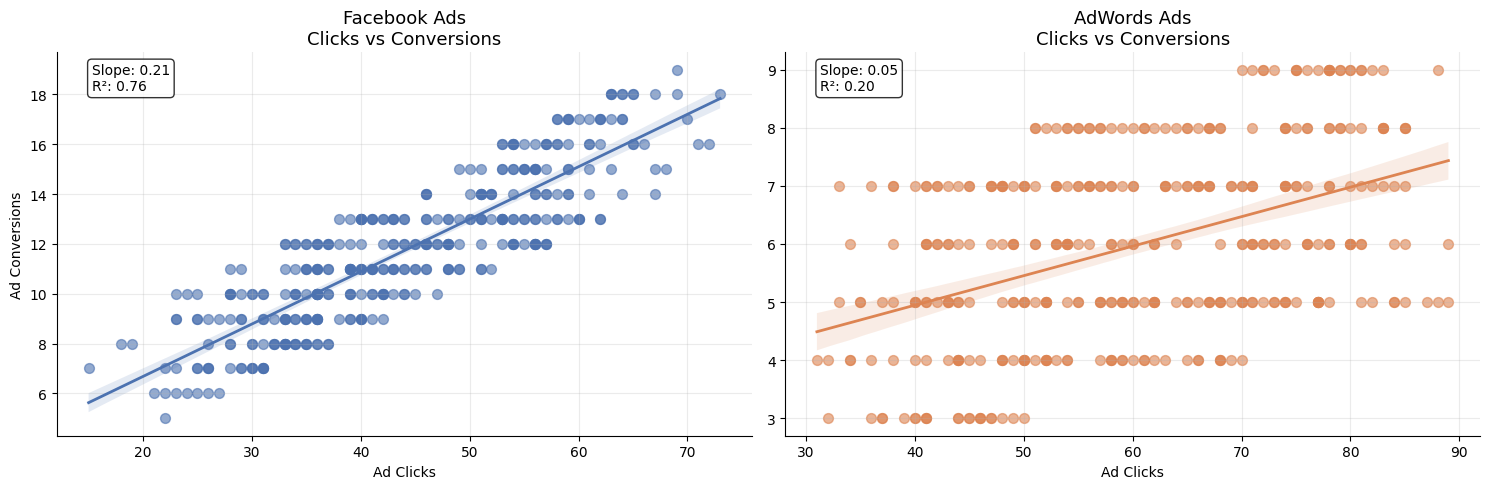

In [25]:
plt.figure(figsize=(15, 5))

# Facebook
plt.subplot(1, 2, 1)
sns.regplot(
    x=df['facebook_ad_clicks'],
    y=df['facebook_ad_conversions'],
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'linewidth': 2},
    color=FACEBOOK_COLOR
)

fb_slope = fb_model.coef_[0]
fb_r2 = fb_model.score(
    df[['facebook_ad_clicks']],
    df['facebook_ad_conversions']
)

plt.title('Facebook Ads\nClicks vs Conversions', fontsize=13)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')
plt.text(
    0.05, 0.90,
    f"Slope: {fb_slope:.2f}\nR²: {fb_r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
plt.grid(alpha=0.25)

# AdWords
plt.subplot(1, 2, 2)
sns.regplot(
    x=df['adwords_ad_clicks'],
    y=df['adwords_ad_conversions'],
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'linewidth': 2},
    color=ADWORDS_COLOR
)

aw_slope = aw_model.coef_[0]
aw_r2 = aw_model.score(
    df[['adwords_ad_clicks']],
    df['adwords_ad_conversions']
)

plt.title('AdWords Ads\nClicks vs Conversions', fontsize=13)
plt.xlabel('Ad Clicks')
plt.ylabel('')
plt.text(
    0.05, 0.90,
    f"Slope: {aw_slope:.2f}\nR²: {aw_r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
plt.grid(alpha=0.25)

sns.despine()
plt.tight_layout()
plt.show()


**Linear Regression Analysis Conclusion**

**Regression Model Metrics**
- Facebook: Slope 0.211, R² 0.76 (76%), High predictive power
- AdWords: Slope 0.051, R² 0.20 (20%), Intercept 2.92, Poor predictive power

**Conversion Efficiency Comparison**
- Facebook 4.1x more efficient at converting clicks than AdWords
- Facebook converts ~21% of clicks vs AdWords ~5%
- Facebook conversion rate quadruple AdWords rate

**Model Reliability**
- Facebook R² 0.76: clicks strongly predict conversions
- AdWords R² 0.20: 80% of conversion variation unrelated to click volume, nearly impossible to forecast
- Facebook model 4x better at explaining and predicting outcomes

**Key Findings**
- Facebook delivers consistent, high-intent users converting at predictable rates
- AdWords click volume minimally impacts outcomes; high baseline (2.92) suggests brand searches/existing customers, not new acquisitions
- Facebook's linear relationship enables accurate forecasting and confident scaling

**Business Implications**
- Every dollar on Facebook clicks delivers 4x more conversions than AdWords
- Doubling Facebook clicks predictably doubles conversions; not true for AdWords
- Reallocating budget from AdWords to Facebook yields immediate 4x ROI improvement per click

**Strategic Takeaways**
- Facebook's 0.211 conversion rate = industry-leading efficiency. AdWords' 0.051 rate suggests fundamental targeting/keyword issues. Heavily favor platform with 4x better efficiency and 4x better predictability.

### Logistic Regression (Probability View)

- What increases the probability that a day converts well?
- Define a “successful day” as having above-median conversions.

In [26]:
df['fb_success'] = (
    df['facebook_ad_conversions']
    > df['facebook_ad_conversions'].median()
).astype(int)


In [27]:
X = df[[
    'facebook_ad_clicks',
    'facebook_cost_per_click_ad_cost_clicks',
    'facebook_click_through_rate_clicks_view'
]]
y = df['fb_success']

logit = LogisticRegression()
logit.fit(X, y)

pd.Series(
    np.exp(logit.coef_[0]),
    index=X.columns
)


facebook_ad_clicks                         1.228021
facebook_cost_per_click_ad_cost_clicks     0.306776
facebook_click_through_rate_clicks_view    0.991489
dtype: float64

**Logistic Regression Analysis Conclusion (Facebook Success Factors)**

**Model Overview**
- Predicts Facebook campaign success probability based on three metrics
- Target: fb_success (binary outcome for high-performing campaigns)
- Coefficients expressed as Odds Ratios

**Odds Ratios Interpretation**
- Facebook Ad Clicks: 1.228 (+22.8% per click, strongest positive predictor)
- Cost Per Click (CPC): 0.307 (-69.3% per unit, strongest negative predictor)
- Click-Through Rate (CTR): 0.991 (-0.9% per unit, nearly neutral/insignificant)

**Key Findings**
- Volume is king: Click volume primary success driver
- Cost is killer: High CPC campaigns 3x less likely to succeed; every dollar CPC increase destroys success odds ~70%
- CTR is vanity metric: High CTR doesn't guarantee success if clicks expensive or low-quality

**Strategic Implications**
- Prioritize volume over CTR: 1,000 clicks at 2% CTR outperforms 100 clicks at 10% CTR
- Cost control critical: Aggressive bid optimization and audience refinement to lower costs top priority
- Success formula: High click volume + Low CPC > High CTR + High CPC

**Campaign Optimization Framework**
1. First priority: Reduce CPC (prevents biggest negative impact)
2. Second priority: Scale click volume (leverages strongest positive predictor)
3. Lower priority: CTR optimization (minimal impact on success probability)

**Practical Takeaways**
Don't chase CTR vanity metrics—focus on affordable clicks driving volume. Campaigns fail when CPC too high regardless of other metrics. Budget flows toward audiences/placements delivering cheap, scalable clicks.

### Time Series & Cost Efficiency

When to scale ad spend ?

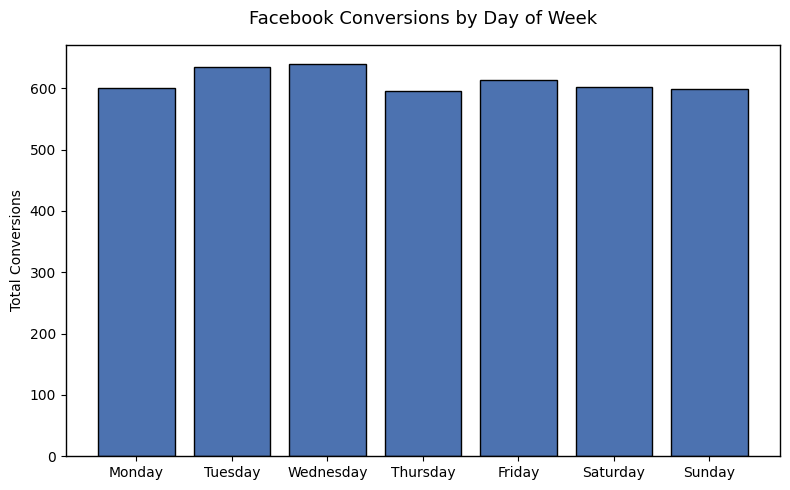

In [28]:
FACEBOOK_COLOR = '#4C72B0'

# Aggregate conversions by day of week
weekly_fb = (
    df
    .groupby(df['date'].dt.day_name())['facebook_ad_conversions']
    .sum()
    .reindex([
        'Monday','Tuesday','Wednesday',
        'Thursday','Friday','Saturday','Sunday'
    ])
)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    weekly_fb.index,
    weekly_fb.values,
    color=FACEBOOK_COLOR,
    edgecolor='black',
    linewidth=1
)

# Styling
ax.set_title('Facebook Conversions by Day of Week', fontsize=13, pad=15)
ax.set_xlabel('')
ax.set_ylabel('Total Conversions')

ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()


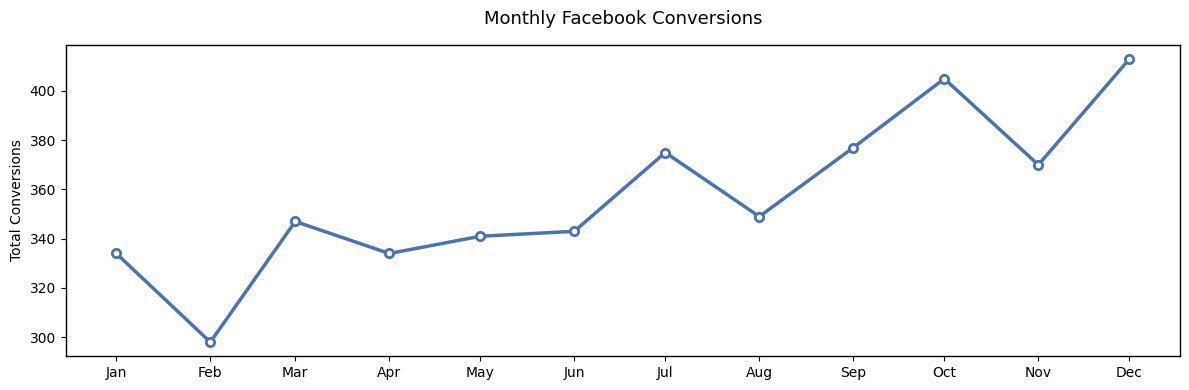

In [29]:
FACEBOOK_COLOR = '#4C72B0'

# Set date as index (required for resample)
df = df.set_index('date')

# Resample monthly conversions (Month Start)
monthly_fb_conversions = (
    df['facebook_ad_conversions']
    .resample('MS')
    .sum()
)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    monthly_fb_conversions.index,
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR,
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)

# Styling
ax.set_title('Monthly Facebook Conversions', fontsize=13, pad=15)
ax.set_xlabel('')
ax.set_ylabel('Total Conversions')

ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.show()


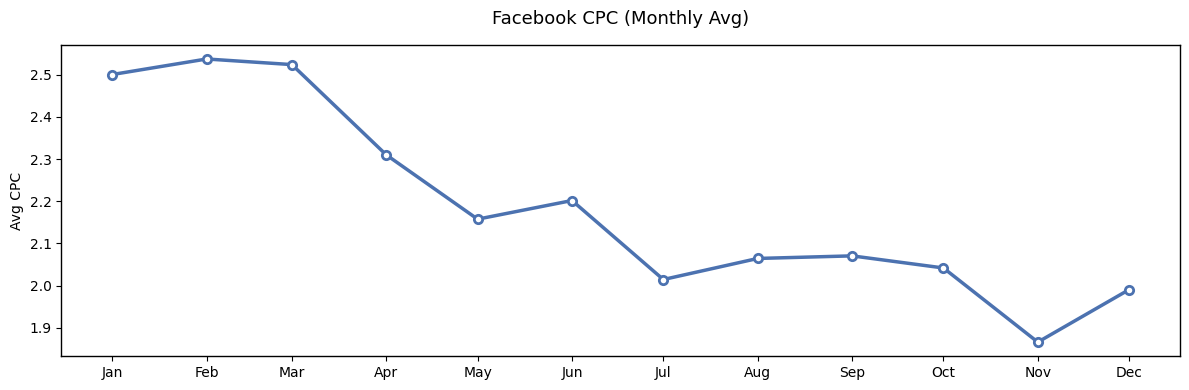

In [39]:
FB_COLOR = '#4C72B0'

fb_cpc_m = df['facebook_cost_per_click_ad_cost_clicks'].resample('MS').mean()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    fb_cpc_m.index,
    fb_cpc_m.values,
    color=FB_COLOR,
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FB_COLOR
)

ax.set_title('Facebook CPC (Monthly Avg)', fontsize=13, pad=15)
ax.set_ylabel('Avg CPC')
ax.set_xlabel('')
ax.grid(False)

# 🔑 FORCE every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()


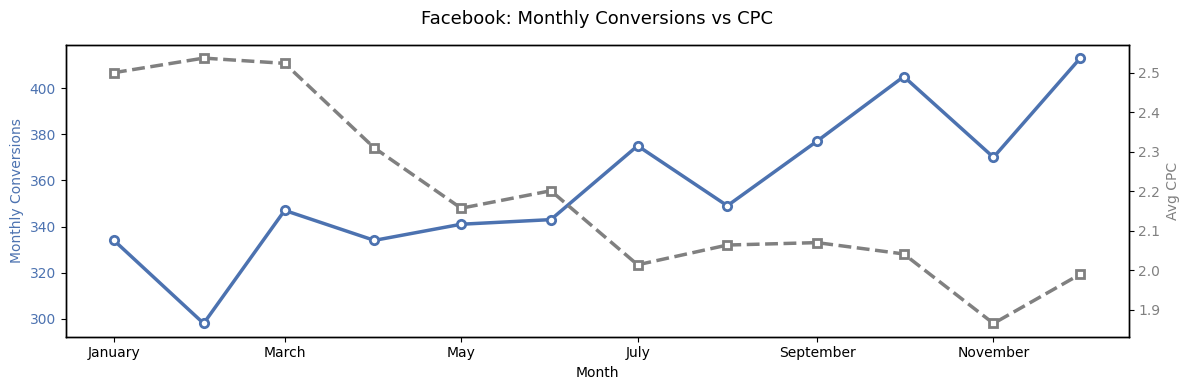

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot conversions with markers
ax1.plot(
    monthly_fb_conversions.index,
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR,
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)
ax1.set_ylabel('Monthly Conversions', color=FACEBOOK_COLOR, fontsize=10)
ax1.tick_params(axis='y', labelcolor=FACEBOOK_COLOR)

# Second y-axis for CPC
ax2 = ax1.twinx()
ax2.plot(
    monthly_fb_cpc.index,
    monthly_fb_cpc.values,
    color='grey',
    linewidth=2.5,
    linestyle='--',
    marker='s',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='grey'
)
ax2.set_ylabel('Avg CPC', color='grey', fontsize=10)
ax2.tick_params(axis='y', labelcolor='grey')

# Styling
ax1.set_title('Facebook: Monthly Conversions vs CPC', fontsize=13, pad=15)
ax1.set_xlabel('Month', fontsize=10)

# Remove gridlines
ax1.grid(False)

# Format x-axis with full month names
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add border
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [32]:


# Cointegration test between Facebook ad cost and conversions
score, p_value, _ = coint(df['cost_per_facebook_ad'], df['facebook_ad_conversions'])

print("Cointegration Test: Facebook Ad Cost vs Conversions")
print("--------------------------------------------------")
print(f"Test Statistic: {score:.4f}")
print(f"P-value       : {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: P-value < 0.05 → Reject the null hypothesis.")
    print("There is evidence of a long-term equilibrium relationship between Facebook ad spend and conversions.")
else:
    print("\nResult: P-value ≥ 0.05 → Fail to reject the null hypothesis.")
    print("No evidence of a stable long-term relationship between Facebook ad spend and conversions.")


Cointegration Test: Facebook Ad Cost vs Conversions
--------------------------------------------------
Test Statistic: -14.7554
P-value       : 0.0000

Result: P-value < 0.05 → Reject the null hypothesis.
There is evidence of a long-term equilibrium relationship between Facebook ad spend and conversions.


**Key Findings**

**Strong Long-Term Relationship Detected**
Cointegration test reveals statistically significant long-term equilibrium between Facebook ad spend and conversions (p-value < 0.0001).

**What This Means**
- Predictable ROI pattern: Ad spending and conversions move together over time in stable, predictable way
- Effective spend-conversion link: Extremely low p-value (0.0000) and strong test statistic (-14.7554) indicate genuine, sustained relationship—not random correlation
- Strategic implications: Confident budget forecasting, reliable optimization outcomes, consistent long-term channel performance

**Business Recommendations**
- Maintain investment: Strong cointegration = reliable value; cutting budget predictably harms conversions
- Scale with confidence: Increasing ad spend yields proportional results based on stable relationship
- Monitor deviations: Short-term divergences (higher spend, fewer conversions) signal when to adjust targeting/creative